In [1]:
import matplotlib.pyplot as plt
import numpy as np
import blip_analysis as ba
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
import importlib
from tqdm import tqdm, trange
from sklearn.preprocessing import StandardScaler
import daskify
import dask
from scipy.stats import ttest_ind
from sklearn.utils import class_weight
from matplotlib.gridspec import GridSpec
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable
import pickle
from sklearn.metrics import confusion_matrix, accuracy_score
importlib.reload(ba)
from label_axes import label_axes
import exp_blip_models as em
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

b


In [2]:
unit_usrt1, unit_usrt2, unit_usrt3= ba.load_usrts()
good_indexes = ba.get_stable_resp_indexes()
unit_usrt1 = unit_usrt1[good_indexes]
unit_usrt2 = unit_usrt2[good_indexes]
unit_usrt3 = unit_usrt3[good_indexes]
glyphs = np.array(ba.get_glyphs())

Found odour 1
Found odour 3
Found odour 5


In [134]:
print(len(good_indexes))

130


In [75]:
dasked  = daskify.Daskified()
dasked.start_cluster()


In [76]:
client = dasked.client

In [6]:
client.status

'running'

In [4]:
units_usrt_long1 = pickle.Unpickler(open('../Fig1/230309_usrt_extended1.pkl', 'rb')).load()[good_indexes]

In [ ]:
def dask_run_classifier(usrt_scattered):
    

In [3]:
mean_usrt1 = np.array([[np.mean(i, axis=0) for i in j] for j in unit_usrt1])
mean_usrt2 = np.array([[np.mean(i, axis=0) for i in j] for j in unit_usrt2])
mean_usrt3 = np.array([[np.mean(i, axis=0) for i in j] for j in unit_usrt3])
mean_usrt_long1 = np.array([[np.mean(i, axis=0) for i in j] for j in units_usrt_long1])

sum_usrt1 = mean_usrt1.sum(axis=-1)
sum_usrt2 = mean_usrt2.sum(axis=-1)
sum_usrt3 = mean_usrt3.sum(axis=-1)
print(mean_usrt1.shape)

NameError: name 'units_usrt_long1' is not defined

In [10]:
train, test = ba.split_bs_data(unit_usrt1, scaler=None)

In [9]:
train.shape

(130, 32, 60, 50)

In [4]:
train_sum = train.sum(axis=-1).reshape(130, -1)
test_sum = test.sum(axis=-1).reshape(130, -1)
scaler = StandardScaler()
scaled_train = scaler.fit_transform(train_sum.T)
scaled_test = sca ler.transform(test_sum.T)
print(np.mean(scaled_train, axis=0).shape)

NameError: name 'train' is not defined

In [3]:
conc_trials = [0, 16, 24, 28, 30, 31]
onset_trials = [16, 8, 4, 2, 1, 0]
iti_trials = [24, 20, 18, 17]
y_train = np.hstack([[i for j in range(60)] for i in range(32)])
y_test = range(32)

In [30]:
train_sum = train.sum(axis=-1)[:, conc_trials].reshape(130, -1)
test_sum = test.sum(axis=-1)[:, conc_trials].reshape(130, -1)
scaler = StandardScaler()
scaled_train = scaler.fit_transform(train_sum.T)
scaled_test = scaler.transform(test_sum.T)
print(np.mean(scaled_train, axis=0).shape)
y_train = np.hstack([[i for j in range(60)] for i in conc_trials])
y_test = conc_trials

(130,)


In [31]:
svm = LinearSVC(C=10)
svm.fit(scaled_train, y_train)
svm.score(scaled_test, y_test)

0.5

In [5]:
def split_and_classify(usrt_scattered, trial_indexes, scaled=True, shuffle=False, unit_count=130, classifier=LinearSVC, classifier_params={}):
    unit_indexes = np.random.choice(range(130), replace=False, size=unit_count)
    train, test = ba.split_bs_data(usrt_scattered[unit_indexes])
    train_sum = train.sum(axis=-1)[:, trial_indexes].reshape(unit_count, -1).T
    test_sum = test.sum(axis=-1)[:, trial_indexes].reshape(unit_count, -1).T
    y_train = np.hstack([[i for j in range(60)] for i in trial_indexes])
    y_test = trial_indexes
    
    if scaled:
        scaler = StandardScaler()
        train_sum = scaler.fit_transform(train_sum)
        test_sum = scaler.transform(test_sum)
    svm = classifier(**classifier_params)
    if shuffle:
        np.random.shuffle(y_train)
    svm.fit(train_sum, y_train)
    print(dir(svm))
    return svm.score(test_sum, y_test), svm.predict(test_sum)


def split_and_classify_joined_labels(usrt_scattered, y_labels, scaled=True, shuffle=False, unit_count=130, classifier=LinearSVC, classifier_params={}):
    unit_indexes = np.random.choice(range(130), replace=False, size=unit_count)
    train, test = ba.split_bs_data(usrt_scattered[unit_indexes])
    train_sum = train.sum(axis=-1).reshape(unit_count, -1).T
    test_sum = test.sum(axis=-1).reshape(unit_count, -1).T
    y_train = np.hstack([[i for j in range(60)] for i in y_labels])
    y_test = y_labels
    if scaled:
        scaler = StandardScaler()
        train_sum = scaler.fit_transform(train_sum)
        test_sum = scaler.transform(test_sum)
    svm = classifier(**classifier_params)
    print(svm)
    if shuffle:
        np.random.shuffle(y_train)
    svm.fit(train_sum, y_train)
    return svm.score(test_sum, y_test), svm.predict(test_sum)

def plot_mean_and_std(ax, data, axis=0, xs = None, sem=False, color=None, label=None):
    mean_data = np.mean(data, axis=axis)
    if xs is None:
        xs = np.arange(len(mean_data))
    std_data = np.std(data, axis=axis)
    if sem:
        std_data = std_data / np.sqrt(data.shape[axis])
    mins = mean_data - std_data
    maxs = mean_data + std_data
    ax.plot(xs, mean_data, color=color, label=label)
    ax.fill_between(xs, mins, maxs, alpha=0.5, color=color)

def set_global_ylim(axs):
    ylims = np.array([i.get_ylim() for i in axs])
    ymax = np.max(ylims[:, 1])
    ymin = np.min(ylims[:, 0])
    [i.set_ylim(ymin, ymax) for i in axs]
# scores = []
# for i in trange(50):
#     scores.append(split_and_svc())

In [6]:
split_and_classify(unit_usrt1, range(32), classifier=RandomForestClassifier)

['__abstractmethods__', '__annotations__', '__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__getitem__', '__getstate__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__iter__', '__le__', '__len__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__setstate__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', '_abc_impl', '_check_feature_names', '_check_n_features', '_compute_oob_predictions', '_estimator_type', '_get_oob_predictions', '_get_param_names', '_get_tags', '_make_estimator', '_more_tags', '_repr_html_', '_repr_html_inner', '_repr_mimebundle_', '_required_parameters', '_set_oob_score_and_attributes', '_validate_X_predict', '_validate_data', '_validate_estimator', '_validate_y_class_weight', 'apply', 'base_estimator', 'base_estimator_', 'bootstrap', 'ccp_alpha', 'class_weight', 'classes_', 'criterion', 'decision_path', 'estimator_pa

(0.28125,
 array([ 0,  1,  3,  3,  7,  5,  5,  6,  5, 11, 17, 12, 22, 15, 23, 13, 16,
        17, 19, 18, 22, 20, 12, 21, 31, 25, 27, 27, 31, 27, 30, 27]))

In [73]:
split_and_classify_joined_labels(unit_usrt1, labs_conc, classifier=RandomForestClassifier, classifier_params={'class_weight':'balanced'})

RandomForestClassifier(class_weight='balanced')


(0.40625,
 array([0, 0, 0, 1, 1, 1, 1, 1, 1, 2, 1, 1, 2, 2, 2, 2, 1, 1, 1, 1, 2, 2,
        2, 2, 2, 2, 3, 2, 3, 2, 2, 3]))

In [77]:
usrt_scattered1 = client.scatter(unit_usrt1)
usrt_scattered2 = client.scatter(unit_usrt2)
usrt_scattered3 = client.scatter(unit_usrt3)


In [24]:
dask_outs = []
for usrt in [usrt_scattered1, usrt_scattered2, usrt_scattered3]:
    for trial_indexes in [conc_trials, onset_trials, iti_trials]:
        for unit_count in range(1, 131):
            for j in range(100):
                dask_outs.append(dask.delayed(split_and_classify)(usrt, trial_indexes, True, False, unit_count, RandomForestClassifier))


In [23]:
dask_outs = []
for trial_indexes in [conc_trials, onset_trials, iti_trials]:
    for unit_count in range(1, 131):
        for j in range(100):
            dask_outs.append(dask.delayed(split_and_classify)(usrt_scattered1, trial_indexes, True, True, unit_count))

In [229]:
dask_outs = []
for usrt_scattered in [usrt_scattered1, usrt_scattered2, usrt_scattered3]:
    for j in range(100):
        dask_outs.append(dask.delayed(split_and_classify)(usrt_scattered, range(32), True, False, 130, RandomForestClassifier))
dask_futures = client.compute(dask_outs)

(130, 32)


In [25]:
dask_futures = client.compute(dask_outs)

In [234]:
dasked.current_futures = dask_futures
dasked.check_progress()

finished 300


In [235]:
full_res = np.array(client.gather(dask_futures)).reshape(3, 100, 2)
full_scores = full_res[:,:,  0]
full_preds = full_res[:,:, 1]
full_preds = np.array([np.vstack(i) for i in full_preds])

In [236]:
pickle.dump(full_res, open('../Fig3/230315_full_classifier_RFs.pkl', 'wb'), protocol=pickle.HIGHEST_PROTOCOL)

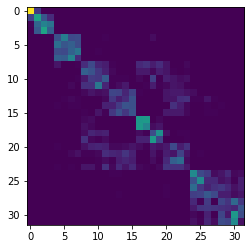

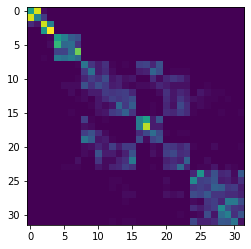

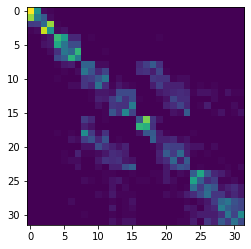

In [100]:
cms = []
for k in range(3):
    flat_preds = full_preds[k].flatten()
    flat_trues = [i for j in range(100) for i in range(32)]
    cm = confusion_matrix(flat_trues, flat_preds, normalize='true')
    plt.figure()
    plt.imshow(cm)
    cms.append(cm.ravel())

In [101]:
print(np.corrcoef(cms))

[[1.         0.75548878 0.81119942]
 [0.75548878 1.         0.84855903]
 [0.81119942 0.84855903 1.        ]]


In [71]:
dasked.check_progress()

finished 117000


In [126]:
res_shuf = client.gather(dask_futures)

In [128]:
res_shuf = np.array(res_shuf).reshape(3, 130, 100, 2)
scores_shuf = res_shuf[:, :, :, 0].astype(float)
preds_shuf = res_shuf[:, :, :, 1]

In [69]:
#res = [i.result() for i in tqdm(dask_futures, position=0, leave=False)]
res = client.gather(dask_futures)
res = np.array(res).reshape(3, 3, 130, 100, 2)
scores = res[:, :, :, :, 0].astype(float)
preds = np.array(list(res[:, :, :, :, 1]))

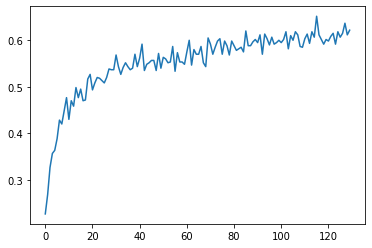

In [70]:
plt.plot(np.mean(scores[0, 0], axis=1))

In [126]:
pickle.dump(res, open('220315_classifier_score_and_preds_RF.pkl', 'wb'), protocol=pickle.HIGHEST_PROTOCOL)

In [153]:
pickle.dump(res_shuf, open('220313_classifier_score_and_preds_shuf.pkl', 'wb'), protocol=pickle.HIGHEST_PROTOCOL)

In [12]:
res = pickle.Unpickler(open('220313_classifier_score_and_preds.pkl', 'rb')).load()
res_shuf = pickle.Unpickler(open('220313_classifier_score_and_preds_shuf.pkl', 'rb')).load()
res_rf = pickle.Unpickler(open('220315_classifier_score_and_preds_RF.pkl', 'rb')).load()

In [13]:
#res_reshaped = res.reshape(3, 3, 130, 100, 2)
scores = res[:, :, :, :, 0].astype(float)
preds = np.array(list(res[:, :, :, :, 1]))
scores_shuf = res_shuf[:, :, :, 0].astype(float)
preds_shuf = res_shuf[:, :, :, 1]
scores_rf = res_rf[:, :, :, :, 0].astype(float)
preds_rf = res_rf[:, :, :, :, 1]

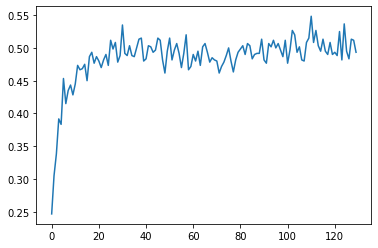

In [6]:
plt.plot(np.mean(scores[0, 0], axis=1))

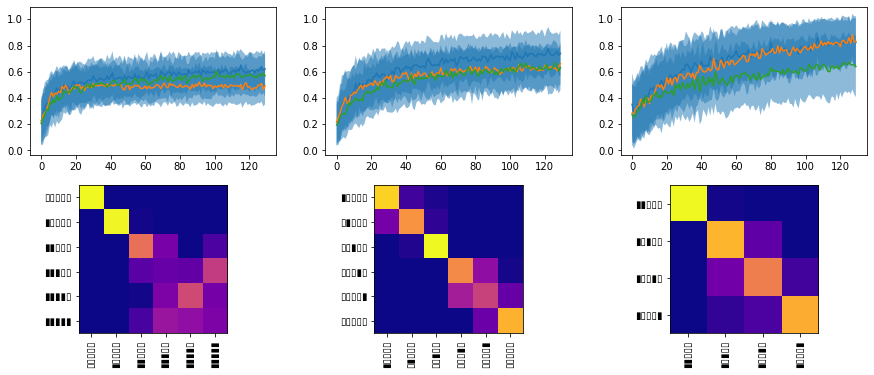

In [18]:
# def plot_heatmap(ax, trues, preds, labels):
#     cm = confusion_matrix(trues, preds, normalize='true', labels=labels)
#     ax.imshow(cm, cmap='plasma')
#     ax.set_xticks(range(len(labels)))
#     ax.set_xticklabels(glyphs[labels], rotation=90)
#     ax.set_yticks(range(len(labels)))
#     ax.set_yticklabels(glyphs[labels])
#     ax.set_ylim(len(labels)-0.5, -0.5)

fig = plt.figure(figsize=(15, 6))

ax1 = fig.add_subplot(231)
ax2 = fig.add_subplot(232)
ax3 = fig.add_subplot(233)
heatmap_ax1 = fig.add_subplot(234)
heatmap_ax2 = fig.add_subplot(235)
heatmap_ax3 = fig.add_subplot(236)
for i in range(3):
    plot_mean_and_std(ax1, scores_rf[i, 0], axis=-1)
    plot_mean_and_std(ax2, scores_rf[i, 1], axis=-1)
    plot_mean_and_std(ax3, scores_rf[i, 2], axis=-1)
c_trues = [i for j in range(100) for i in conc_trials]
o_trues = [i for j in range(100) for i in onset_trials]
i_trues = [i for j in range(100) for i in iti_trials]
plot_heatmap(heatmap_ax1, np.hstack(preds_rf[0, 0, -1]), c_trues, conc_trials)
plot_heatmap(heatmap_ax2, np.hstack(preds_rf[0, 1, -1]), o_trues, onset_trials)
plot_heatmap(heatmap_ax3, np.hstack(preds_rf[0, 2, -1]), i_trues, iti_trials)
set_global_ylim([ax1, ax2, ax3])
# plot_mean_and_std(ax1, scores_shuf[0], axis=-1)
# plot_mean_and_std(ax2, scores_shuf[1], axis=-1)
# plot_mean_and_std(ax3, scores_shuf[2], axis=-1)

In [ ]:
print(scores.shape)
print(scores_shuf.shape)
for i in range(10):
    print(i)
    print('odour 1 conc', ttest_ind(scores[0, 0, i], scores_shuf[0, i]))
    print('odour 2 conc', ttest_ind(scores[1, 0, i], scores_shuf[0, i]))
    print('odour 3 conc', ttest_ind(scores[2, 0, i], scores_shuf[0, i]))
    
    print('odour 1 onset', ttest_ind(scores[0, 1, i], scores_shuf[1, i]))
    print('odour 2 onset', ttest_ind(scores[1, 1, i], scores_shuf[1, i]))
    print('odour 3 onset', ttest_ind(scores[2, 1, i], scores_shuf[1, i]))
    
    print('odour 1 iti', ttest_ind(scores[0, 2, i], scores_shuf[2, i]))
    print('odour 2 iti', ttest_ind(scores[1, 2, i], scores_shuf[2, i]))
    print('odour 3 iti', ttest_ind(scores[2, 2, i], scores_shuf[2, i]))
    
    

In [75]:
mean_res = np.mean(res, axis=2)


(3, 3, 130, 2)


{'bodies': [<matplotlib.collections.PolyCollection at 0x7fb2ba8de668>,
 'cmeans': <matplotlib.collections.LineCollection at 0x7fb2ba8de240>,
 'cmaxes': <matplotlib.collections.LineCollection at 0x7fb2ba8dedd8>,
 'cmins': <matplotlib.collections.LineCollection at 0x7fb2ba8fa048>,
 'cbars': <matplotlib.collections.LineCollection at 0x7fb2ba8de470>}

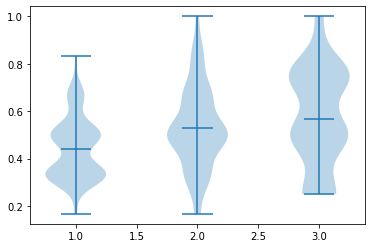

In [24]:
# joint_scores = np.append(scores[1], scores_shuf[np.newaxis, :], axis=0)
plt.violinplot(scores[1].T, showmeans=True)

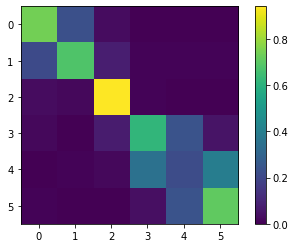

In [108]:
pred_indi = np.stack(preds[0, 1]).flatten()
trues = [i for j in range(100) for i in onset_trials ]
cm = confusion_matrix(trues, pred_indi, labels=onset_trials, normalize='true')
plt.imshow(cm)
plt.colorbar()

In [45]:
onset_scores = []
iti_scores = []
for i in trange(50):
    onset_scores.append(split_and_svc(onset_trials))
    iti_scores.append(split_and_svc(iti_trials))

100%|██████████| 50/50 [00:38<00:00,  1.29it/s]


In [ ]:
scores_base = []
for i in trange(50):
    scores_base.append(split_and_svc(scaled=False))

{'bodies': [<matplotlib.collections.PolyCollection at 0x7fa359527908>,
 'cmaxes': <matplotlib.collections.LineCollection at 0x7fa3595b03c8>,
 'cmins': <matplotlib.collections.LineCollection at 0x7fa359527a20>,
 'cbars': <matplotlib.collections.LineCollection at 0x7fa359518320>}

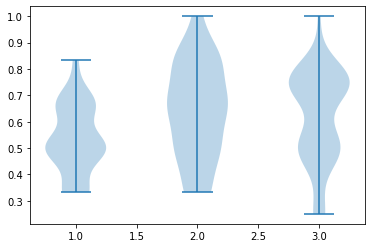

In [46]:
plt.violinplot([scores, onset_scores, iti_scores])

In [102]:
y_train = np.hstack([[i for j in range(60)] for i in range(32)])
y_test = range(32)

In [4]:
labs_onset = np.where(em.trial_arrays['cao_array'][:, :5] == 1)[1]
labs_conc = np.where(em.trial_arrays['cao_array'][:, 5:] == 1)[1]
labs_conc = np.append([-1], labs_conc)
labs_onset = np.append([5], labs_onset)


In [120]:
print(labs_onset)

[5 4 3 3 2 2 2 2 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


In [35]:
split_and_svc_joined_labels(unit_usrt1, labs_onset, )

/camp/home/warnert/.conda/envs/blip_manu/lib/python3.7/site-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,


(0.8125,
 array([4, 5, 4, 3, 2, 2, 2, 2, 1, 1, 1, 2, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0]))

In [93]:
dask_outs = []
for usrt in [usrt_scattered1, usrt_scattered2, usrt_scattered3]:
    for trial_indexes in [labs_conc, labs_onset]:
        for unit_count in range(1, 131):
            for j in range(100):
                dask_outs.append(dask.delayed(split_and_classify_joined_labels)(usrt, trial_indexes, True, False, unit_count, RandomForestClassifier, {'class_weight':'balanced'}))
dask_outs = client.compute(dask_outs)

In [92]:
split_and_classify_joined_labels(unit_usrt1, labs_conc, True, False, 10, RandomForestClassifier, {"class_weight":'balanced'})

RandomForestClassifier(class_weight='balanced')


(0.4375,
 array([0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 2, 2, 1, 2, 2, 1, 1, 0, 0, 2, 2, 2,
        3, 1, 2, 2, 1, 2, 2, 1, 2, 1]))

In [45]:
print(future)

<Future: cancelled, key: split_and_svc_joined_labels-c51552fd-da46-4901-8ba5-87b6d4cfefa8>


In [114]:
dasked.current_futures = dask_outs
dasked.check_progress()
#client.cancel(dask_outs)

finished 78000


In [5]:
res_joined = np.array(client.gather(dask_outs)).reshape(3, 2, 130, 100, 2)#np.array([i.result() for i in tqdm(dask_outs, position=0, leave=False)]).reshape(3, 2, 100, 2)
scores_joined = res_joined[:, :,:, :,0].astype(float)
preds_joined = res_joined[:, :, :, :, 1]

NameError: name 'client' is not defined

In [ ]:
plt.violinplot(scores_joined[0].T)

In [35]:
RandomForestClassifier()
print(labs_onset[onset_trials])

[0 1 2 3 4 5]


In [225]:
pickle.dump(res_joined, open('220315_classifier_score_and_preds_joined_RF.pkl', 'wb'), protocol=pickle.HIGHEST_PROTOCOL)

In [6]:
res_joined_rf = pickle.Unpickler(open('220315_classifier_score_and_preds_joined_RF.pkl', 'rb')).load()
scores_joined_rf = res_joined_rf[:, :, :, :, 0].astype(float)
preds_joined_rf = res_joined_rf[:, :, :, :, 1]

In [7]:
c_joined_true = [i for j in range(100) for i in labs_conc]
o_joined_true = [i for j in range(100) for i in labs_onset]

In [80]:
class_weight.compute_class_weight('balanced', classes=np.unique(labs_conc), y=labs_conc)

array([5.33333333, 1.06666667, 0.53333333, 0.53333333, 1.06666667,
       5.33333333])

NameError: name 'conc_trials' is not defined

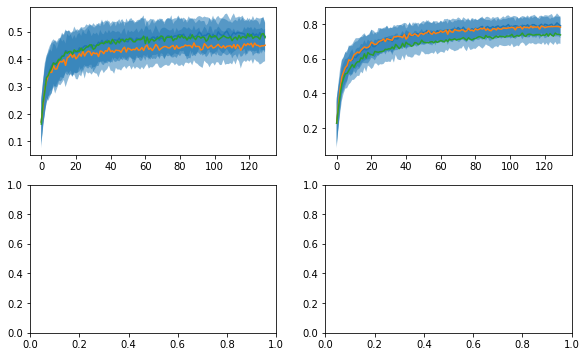

In [15]:
def plot_heatmap(ax, trues, preds, labels, set_glyphs=True):
    cm = confusion_matrix(trues, preds, normalize='true', labels=labels)
    im = ax.imshow(cm, cmap='plasma')
    ax.set_xticks(range(len(labels)))
    ax.set_yticks(range(len(labels)))
    ax.set_ylim(len(labels)-0.5, -0.5)
    if set_glyphs:
        ax.set_xticklabels(glyphs[labels], rotation=90)
        ax.set_yticklabels(glyphs[labels])
    else:
        ax.set_xticklabels(labels, rotation=90)
        ax.set_yticklabels(labels)
    return im, np.max(cm), cm

fig = plt.figure(figsize=(15, 6))

ax1 = fig.add_subplot(231)
ax2 = fig.add_subplot(232)
#ax3 = fig.add_subplot(233)
heatmap_ax1 = fig.add_subplot(234)
heatmap_ax2 = fig.add_subplot(235)
#heatmap_ax3 = fig.add_subplot(236)
for i in range(3):
    plot_mean_and_std(ax1, scores_joined_rf[i, 0], axis=-1)
    plot_mean_and_std(ax2, scores_joined_rf[i, 1], axis=-1)
    #plot_mean_and_std(ax3, scores_joined_rf[i, 2], axis=-1)
c_trues = [i for j in range(100) for i in conc_trials]
o_trues = [i for j in range(100) for i in onset_trials]

#i_trues = [i for j in range(100) for i in iti_trials]
plot_heatmap(heatmap_ax1, np.hstack(preds_joined_rf[0, 0, -1]), c_joined_true, [-1, 0, 1, 2, 3, 4, ], set_glyphs=False)
plot_heatmap(heatmap_ax2, np.hstack(preds_joined_rf[0, 1, -1]), o_joined_true, [0, 1, 2, 3, 4, 5], set_glyphs=False)
heatmap_ax1.set_yticklabels(['None', 1, 2, 3, 4, 5])
heatmap_ax1.set_xticklabels(['None', 1, 2, 3, 4, 5])
heatmap_ax2.set_yticklabels([0, 20, 40, 60, 80, 'N/A'])
heatmap_ax2.set_xticklabels([0, 20, 40, 60, 80, 'N/A'])
#plot_heatmap(heatmap_ax3, np.hstack(preds_joined_rf[0, 2, -1]), i_trues, iti_trials)
set_global_ylim([ax1, ax2])
# plot_mean_and_std(ax1, scores_shuf[0], axis=-1)
# plot_mean_and_std(ax2, scores_shuf[1], axis=-1)
# plot_mean_and_std(ax3, scores_shuf[2], axis=-1)

NameError: name 'plot_mean_and_std' is not defined

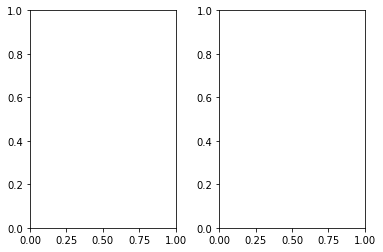

In [8]:
def forceAspect(ax,aspect=1):
    extent = ax.get_xlim() + ax.get_ylim()
    print(extent)
    ax.set_aspect(abs((extent[1]-extent[0])/(extent[3]-extent[2]))/aspect)

fig = plt.figure()
glob_gs = GridSpec(1, 1)

def plot_classifier_acc_and_pred(fig, glob_gs, scores, preds, true_labels, ticklabels=None, force_aspect=True):
    
    gs = glob_gs.subgridspec(1, 2, wspace=0.3)
    ax1 = fig.add_subplot(gs[0])
    ax2 = fig.add_subplot(gs[1])
    for i in range(3):
        plot_mean_and_std(ax1, scores[i], axis=-1)

    plot_heatmap(ax2, np.hstack(preds), true_labels, np.unique(true_labels))
    if ticklabels is not None:
        ax2.set_yticklabels(ticklabels);
        ax2.set_xticklabels(ticklabels);
    ax2.set_xlabel('Predicted label')
    ax2.set_ylabel('True label')
    ax1.set_ylabel('Accuracy')
    ax1.set_xlabel('Number of neuron')
    if force_aspect:
        forceAspect(ax1)
    return [ax1, ax2]
plot_classifier_acc_and_pred(fig, glob_gs[0], scores_joined_rf[:, 0], preds_joined_rf[0, 0, -1], c_joined_true, ['None', 1, 2, 3, 4, 5])

In [10]:
y_true = [j for i in range(100) for j in range(6)]

cm = confusion_matrix(y_true, np.vstack(preds_joined[0, 1])[:, onset_trials].flatten(), normalize='true')
print(np.vstack(preds_joined[0, 1])[:, onset_trials].flatten())

NameError: name 'preds_joined' is not defined

[25 50 75]


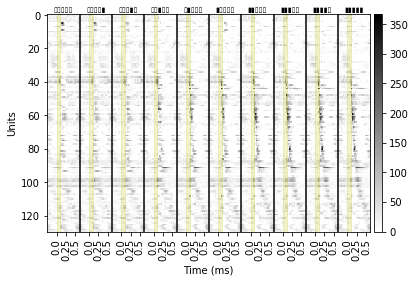

In [17]:
def plot_resp_heatmap(ax, mean_usrt, select_trials, sorted_args=None, time_offset=25, cmap='binary', time_ticks_base = None, colorbar_ax=None):  
    if sorted_args is None:
        sorted_args = np.argsort(np.argmax(mean_usrt[:, select_trials[::-1][-1]], axis=-1))
    im = ax.imshow(mean_usrt[sorted_args][:, select_trials[::-1], time_offset:].reshape(130, -1), cmap=cmap, aspect='auto')
    ax.axvspan(50-time_offset, 50-time_offset+10, color='y', alpha=0.2)
    time_len = mean_usrt.shape[-1] - time_offset
    if time_ticks_base is None:
        pre_window = time_offset/100 - .5
        post_window = time_len/100 + pre_window
        
        time_ticks_base = np.arange(pre_window, post_window, -1*pre_window)
        print(time_ticks_base)
    full_xs = np.arange(time_offset/100-.5, time_len/100, 1/100).round(2)
    #print(full_xs.round(2))
    xticks_base = np.array([np.where(full_xs == i)[0][0] for i in time_ticks_base])
    
 #   xticks_base = np.linspace(0, time_len, int(pre_window*-100))
    print(xticks_base)
    time_ticks = []
    xticks = []
    for i in range(len(select_trials)):
        xticks.append(xticks_base+i*time_len)
        time_ticks.append(time_ticks_base)

    ax.set_xticks(np.concatenate(xticks))
    
    ax.set_xticklabels(np.concatenate(time_ticks), rotation=90)
    for i in range(1, 10):
        ax.axvline(87*i, color='k')
        ax.axvspan(25+87*i, 35+87*i, color='y', alpha=0.2)
        ax.text(17+87*i, -2, glyphs[select_trials[::-1][i]], fontsize=7)
    if colorbar_ax is None:
        divider = make_axes_locatable(ax)
        cax = divider.append_axes('right', size='2.5%', pad=0.05)
        plt.colorbar(mappable=im, cax=cax)
    else:
        plt.colorbar(mappable=im, cax=colorbar_ax)
    ax.text(17, -2, glyphs[select_trials[-1]], fontsize=7)
    ax.set_xlabel('Time (ms)')
    ax.set_ylabel('Units')
    
fig = plt.figure()
ax = fig.add_subplot(111)
select_trials = [31, 30, 28, 24, 16, 8, 4, 2, 1, 0]
plot_resp_heatmap(ax, mean_usrt_long1, select_trials, time_ticks_base=[0, 0.25, 0.5])

In [170]:
mean_usrt_long1.shape

(130, 32, 112)

[25 50 75]
(3, 3, 130, 100)
(-6.45, 135.45, 0.0035475332783923078, 0.8110616144950462)
(-6.45, 135.45, -0.01524225701292991, 0.9872961051885805)
(-6.45, 135.45, -0.037390396951931845, 1.093821014447636)
(-6.45, 135.45, 0.050628052032455365, 0.5917907070360976)
(-6.45, 135.45, 0.044463950126974974, 0.9023943725802817)
(-6.45, 135.45, -0.037390396951931845, 1.093821014447636)
(-6.45, 135.45, -0.037390396951931845, 1.093821014447636)
(-6.45, 135.45, -0.037390396951931845, 1.093821014447636)
(-6.45, 135.45, -0.037390396951931845, 1.093821014447636)
(-6.45, 135.45, -0.037390396951931845, 1.093821014447636)


[None, None, None, None, None]

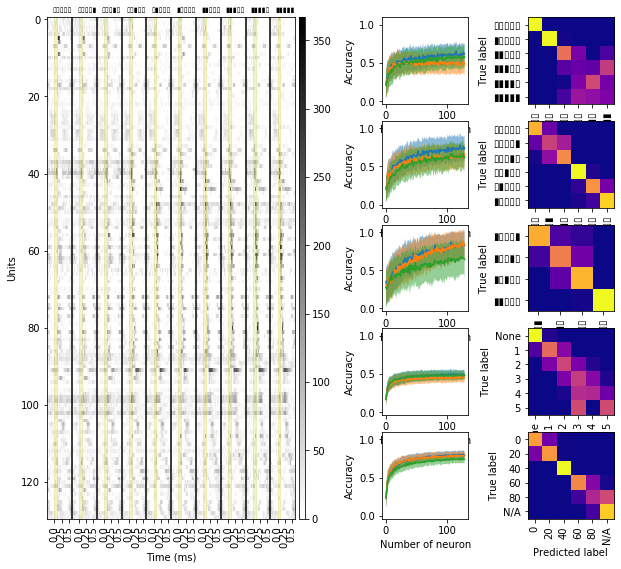

In [41]:
fig = plt.figure(figsize=(8.3, 8))
gs = GridSpec(5, 2,wspace=.25, left=0.0, right=0.97, bottom=0.1, top=0.97)
time_heatmap_ax = fig.add_subplot(gs[:, 0])
plot_resp_heatmap(time_heatmap_ax, mean_usrt_long1, select_trials, time_ticks_base=[0, 0.25, 0.5])
# conc_ax = fig.add_subplot(gs[0, 1])
# onset_ax = fig.add_subplot(gs[1, 1])
# iti_ax = fig.add_subplot(gs[2, 1])
# conc_joined_ax = fig.add_subplot(gs[3, 1])
# onset_joined_ax = fig.add_subplot(gs[4, 1])
print(scores_rf.shape)
c_ax1, c_ax2 = plot_classifier_acc_and_pred(fig, gs[0,1 ], scores_rf[:, 0], preds_rf[0, 0, -1], c_trues)
o_ax1, o_ax2 = plot_classifier_acc_and_pred(fig, gs[1,1 ], scores_rf[:, 1], preds_rf[0, 1, -1], o_trues)
i_ax1, i_ax2 = plot_classifier_acc_and_pred(fig, gs[2,1 ], scores_rf[:, 2], preds_rf[0, 2, -1], i_trues)
cj_ax1, cj_ax2 = plot_classifier_acc_and_pred(fig, gs[3,1 ], scores_joined_rf[:, 0], preds_joined_rf[0, 0, -1], c_joined_true, ['None', 1, 2, 3, 4, 5])
oj_ax1, oj_ax2 = plot_classifier_acc_and_pred(fig, gs[4,1 ], scores_joined_rf[:, 1], preds_joined_rf[0, 1, -1], o_joined_true, [0, 20, 40, 60, 80, 'N/A'])
set_global_ylim([c_ax1, o_ax1, i_ax1, cj_ax1, oj_ax1])
[forceAspect(i) for i in [c_ax1, o_ax1, i_ax1, cj_ax1, oj_ax1]]

In [ ]:
fig = plt.figure(figsize=(8.3, 8))
gs = GridSpec(,wspace=.25, left=0.0, right=0.97, bottom=0.1, top=0.97)
print(scores_rf.shape)
c_ax1, c_ax2 = plot_classifier_acc_and_pred(fig, gs[0,1 ], scores_rf[:, 0], preds_rf[0, 0, -1], c_trues)
o_ax1, o_ax2 = plot_classifier_acc_and_pred(fig, gs[1,1 ], scores_rf[:, 1], preds_rf[0, 1, -1], o_trues)
i_ax1, i_ax2 = plot_classifier_acc_and_pred(fig, gs[2,1 ], scores_rf[:, 2], preds_rf[0, 2, -1], i_trues)
cj_ax1, cj_ax2 = plot_classifier_acc_and_pred(fig, gs[3,1 ], scores_joined_rf[:, 0], preds_joined_rf[0, 0, -1], c_joined_true, ['None', 1, 2, 3, 4, 5])
oj_ax1, oj_ax2 = plot_classifier_acc_and_pred(fig, gs[4,1 ], scores_joined_rf[:, 1], preds_joined_rf[0, 1, -1], o_joined_true, [0, 20, 40, 60, 80, 'N/A'])
set_global_ylim([c_ax1, o_ax1, i_ax1, cj_ax1, oj_ax1])
[forceAspect(i) for i in [c_ax1, o_ax1, i_ax1, cj_ax1, oj_ax1]]

(-6.45, 135.45, 0.0, 0.9319821014447636)
(-6.45, 135.45, 0.0, 0.9319821014447636)
(-6.45, 135.45, 0.0, 0.9319821014447636)
(-6.45, 135.45, 0.0, 0.9319821014447636)
(-6.45, 135.45, 0.0, 0.9319821014447636)


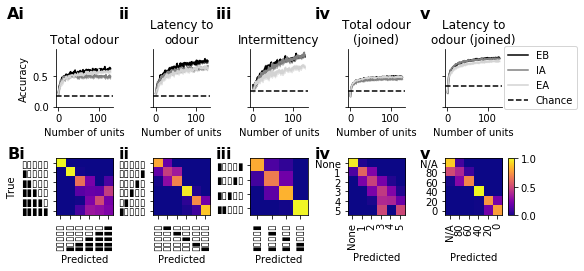

In [34]:
fig = plt.figure(figsize=(8, 4))
gs = GridSpec(2, 5, wspace=0.7, hspace=0)
acc_ax1 = fig.add_subplot(gs[0, 0])
acc_ax2 = fig.add_subplot(gs[0, 1])
acc_ax3 = fig.add_subplot(gs[0, 2])
acc_ax4 = fig.add_subplot(gs[0, 3])
acc_ax5 = fig.add_subplot(gs[0, 4])
odour_grays = ['k', 'gray', 'lightgray']
labels=['EB', 'IA', 'EA']
for i in range(3):
    plot_mean_and_std(acc_ax1, scores_rf[i, 0], axis=-1, sem=True, color=odour_grays[i])
    plot_mean_and_std(acc_ax2, scores_rf[i, 1], axis=-1, sem=True, color=odour_grays[i])
    plot_mean_and_std(acc_ax3, scores_rf[i, 2], axis=-1, sem=True, color=odour_grays[i])
    plot_mean_and_std(acc_ax4, scores_joined_rf[i, 0], axis=-1, sem=True, color=odour_grays[i])
    plot_mean_and_std(acc_ax5, scores_joined_rf[i, 1], axis=-1, sem=True, color=odour_grays[i], label=labels[i])

acc_ax5.plot([], color='k', linestyle='--', label='Chance')

[i.spines['top'].set_visible(False) for i in [acc_ax1, acc_ax2, acc_ax3, acc_ax4, acc_ax5]]
[i.spines['right'].set_visible(False) for i in [acc_ax1, acc_ax2, acc_ax3, acc_ax4, acc_ax5]]

heatmap_ax1 = fig.add_subplot(gs[1, 0])
heatmap_ax2 = fig.add_subplot(gs[1, 1])
heatmap_ax3 = fig.add_subplot(gs[1, 2])
heatmap_ax4 = fig.add_subplot(gs[1, 3])
heatmap_ax5 = fig.add_subplot(gs[1, 4])
im1, vmax1, cm1 = plot_heatmap(heatmap_ax1, np.hstack(preds_rf[0, 0, -1]), c_trues, np.unique(c_trues))
im2, vmax2, cm2 = plot_heatmap(heatmap_ax2, np.hstack(preds_rf[0, 1, -1]), o_trues, np.unique(o_trues))
im3, vmax3, cm3 = plot_heatmap(heatmap_ax3, np.hstack(preds_rf[0, 2, -1]), i_trues, np.unique(i_trues))
im4, vmax4, cm4 = plot_heatmap(heatmap_ax4, np.hstack(preds_joined_rf[0, 0, -1]), c_joined_true, np.unique(c_joined_true))
im5, vmax5, cm5 = plot_heatmap(heatmap_ax5, np.hstack(preds_joined_rf[0, 1, -1]), o_joined_true, np.unique(o_joined_true)[::-1])
acc_ax1.set_title('Total odour')
acc_ax2.set_title('Latency to\nodour')
acc_ax3.set_title('Intermittency')
acc_ax4.set_title('Total odour\n(joined)')
acc_ax5.set_title('Latency to\nodour (joined)')
heatmap_ax4.set_xticklabels(['None', 1, 2, 3, 4, 5])
heatmap_ax4.set_yticklabels(['None', 1, 2, 3, 4, 5])
heatmap_ax5.set_xticklabels([0, 20, 40, 60, 80, 'N/A'][::-1])
heatmap_ax5.set_yticklabels([0, 20, 40, 60, 80, 'N/A'][::-1])

set_global_ylim([acc_ax1, acc_ax2, acc_ax3, acc_ax4, acc_ax5])
[i.set_ylim(0) for i in [acc_ax1, acc_ax2, acc_ax3, acc_ax4, acc_ax5]]
[forceAspect(i) for i in [acc_ax1, acc_ax2, acc_ax3, acc_ax4, acc_ax5]]
[i.set_yticklabels([]) for i in [acc_ax2 , acc_ax3, acc_ax4, acc_ax5]]
[i.set_xlabel('Number of units') for i in [acc_ax1, acc_ax2, acc_ax3, acc_ax4, acc_ax5]]
acc_ax1.set_ylabel('Accuracy')
heatmap_ax1.set_ylabel('True')
[i.set_xlabel('Predicted') for i in [heatmap_ax1, heatmap_ax2, heatmap_ax3, heatmap_ax4, heatmap_ax5]]
heatmap_ax5.set_xlabel('Predicted', labelpad=12)
axs = [acc_ax1, acc_ax2, acc_ax3, acc_ax4, acc_ax5, heatmap_ax1, heatmap_ax2, heatmap_ax3, heatmap_ax4, heatmap_ax5]
labels = ['Ai', 'ii', 'iii', 'iv', 'v', 'Bi', 'ii', 'iii', 'iv', 'v']
label_axes.label_axes(axs, labels, fontsize=16, fontweight='bold', align_x = [[0, 5], [1, 6], [2, 7], [3, 8], [4, 9]], align_y = [[0, 1, 2, 3, 4], [5, 6, 7, 8, 9]], align_x_fun=np.min, align_y_fun=np.max)
acc_ax5.legend(loc='right', bbox_to_anchor=(2.4, 0.5))
acc_ax1.axhline(1/6, linestyle='--', color='k')
acc_ax2.axhline(1/6, linestyle='--', color='k')
acc_ax3.axhline(1/4, linestyle='--', color='k')
acc_ax4.axhline(0.246, linestyle='--', color='k')
acc_ax5.axhline(0.334, linestyle='--', color='k')
y0 = heatmap_ax5.get_position().y0
h = heatmap_ax5.get_position().height
cbax = fig.add_axes([0.91, y0, 0.01, h])
vmax = np.max([vmax1, vmax2, vmax3, vmax4, vmax5])
[im.set_clim(0, vmax) for im in [im1, im2, im3, im4, im5]]
cbar = plt.colorbar(im5, cax=cbax)
plt.draw()
plt.savefig('230630_Fig2.pdf', bbox_inches='tight')

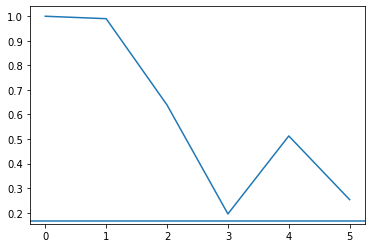

In [97]:
summation_c = 0
summation_o = 0
for i in np.unique(c_joined_true):
    summation_c += (len(np.where(c_joined_true == i)[0])/len(c_joined_true))**2
print(summation_c)
for i in np.unique(o_joined_true):
    summation_o += (len(np.where(o_joined_true == i)[0])/len(o_joined_true))**2
print(summation_o)

0.24609375
0.333984375


In [36]:
    plot_heatmap(ax2, np.hstack(preds), true_labels, np.unique(true_labels))


[0, 16, 24, 28, 30, 31]


In [77]:
print(scores_joined_rf[2, 0].mean(axis=-1))

[0.163125  0.2403125 0.28      0.3321875 0.3403125 0.3565625 0.3678125
 0.3859375 0.381875  0.386875  0.399375  0.3984375 0.410625  0.411875
 0.42625   0.4215625 0.4278125 0.428125  0.418125  0.4340625 0.4284375
 0.43      0.429375  0.440625  0.4309375 0.4375    0.44375   0.4459375
 0.451875  0.4521875 0.4353125 0.4403125 0.4521875 0.4509375 0.4571875
 0.4596875 0.45625   0.4653125 0.46      0.4671875 0.4575    0.4725
 0.4640625 0.455     0.466875  0.459375  0.4721875 0.470625  0.46375
 0.473125  0.4709375 0.475625  0.4715625 0.4634375 0.4634375 0.47
 0.471875  0.4709375 0.473125  0.4840625 0.4571875 0.480625  0.4590625
 0.470625  0.473125  0.4659375 0.4703125 0.475625  0.4778125 0.4846875
 0.4825    0.4646875 0.479375  0.4803125 0.4796875 0.48375   0.4671875
 0.474375  0.47375   0.4853125 0.4778125 0.4865625 0.4771875 0.48125
 0.47      0.480625  0.474375  0.4890625 0.478125  0.47125   0.4828125
 0.4828125 0.4765625 0.4815625 0.4790625 0.4653125 0.471875  0.4871875
 0.4809375 0.480937